In [15]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D

# check GPU(s) availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
data_dir = './datasets/chest_xray'

height, width = 224, 224

batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_dataset = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_dataset.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_dataset.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


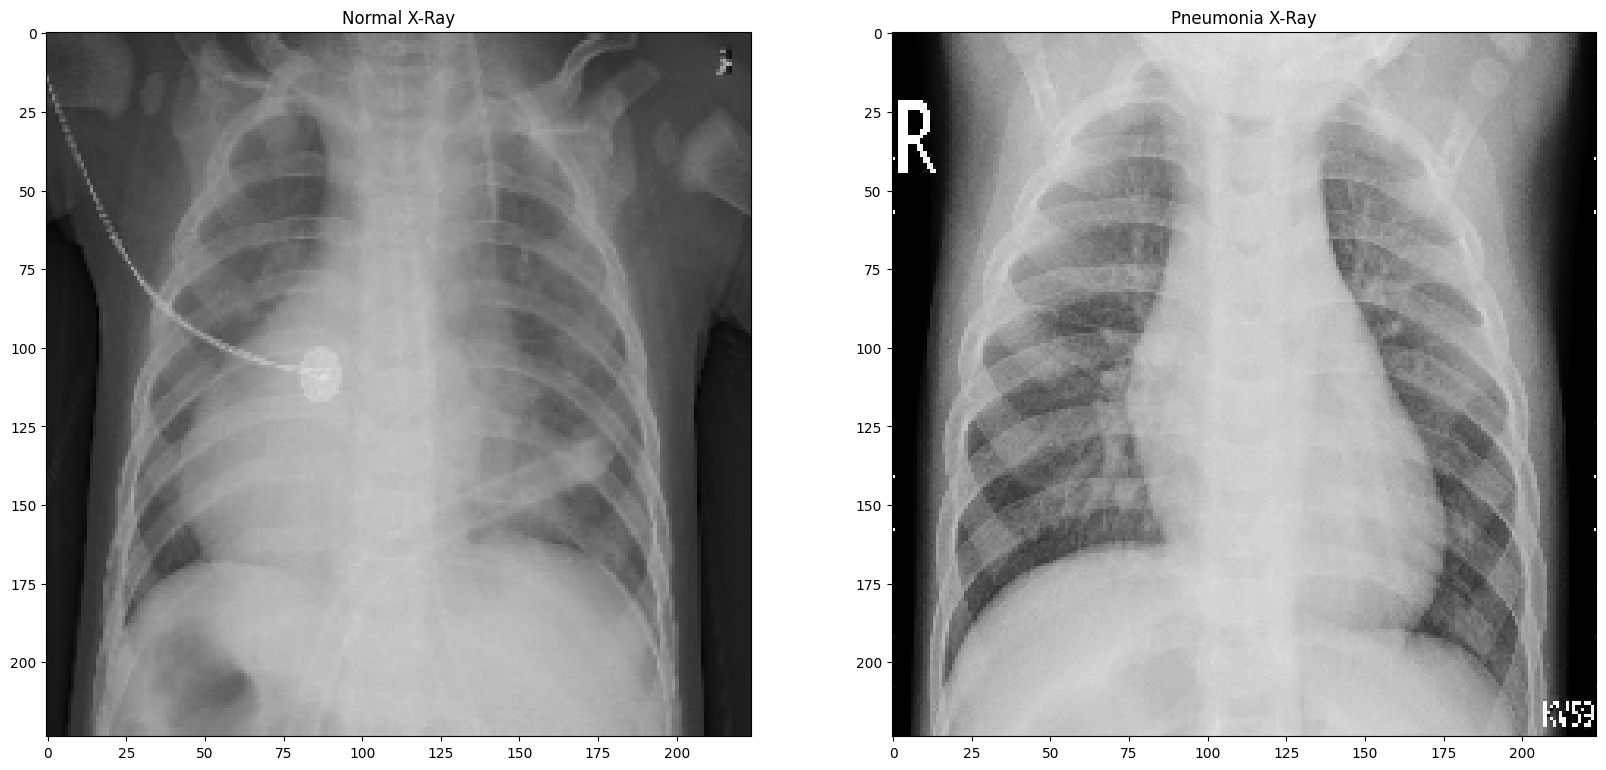

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(train_generator[0][0][0])
ax[0].set_title('Normal X-Ray')
ax[1].imshow(test_generator[0][0][0])
ax[1].set_title('Pneumonia X-Ray')

# save figure
plt.savefig('chest_xray.png')

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='swish', input_shape=(height, width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='gelu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation=tf.keras.activations.relu),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='swish'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

2024-06-03 21:01:04.405417: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 21:01:04.406102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 21:01:04.406302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.535GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2024-06-03 21:01:04.406355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

In [7]:
callback = [
    EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint('./models/best-pneumonia-predictor.h5', save_best_only=True)
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy'],
)

with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=callback,
        verbose=1
    )


2024-06-03 21:01:05.679722: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-06-03 21:01:05.680079: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 4049955000 Hz


Epoch 1/10


2024-06-03 21:01:06.360730: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-06-03 21:01:06.990237: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2024-06-03 21:01:07.729036: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-06-03 21:01:07.729055: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-06-03 21:01:07.729149: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-06-03 21:01:07.773901: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-06-03 21:01:08.302434: I tensorflow/stream_exec

163/163 [==============================] - 58s 339ms/step - loss: 0.4185 - accuracy: 0.8137 - val_loss: 0.9993 - val_accuracy: 0.5625
Epoch 2/10
163/163 [==============================] - 56s 342ms/step - loss: 0.2319 - accuracy: 0.9076 - val_loss: 0.7032 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 54s 334ms/step - loss: 0.2002 - accuracy: 0.9199 - val_loss: 0.8879 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 55s 337ms/step - loss: 0.1750 - accuracy: 0.9340 - val_loss: 0.6747 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 55s 336ms/step - loss: 0.1777 - accuracy: 0.9329 - val_loss: 0.9613 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 55s 336ms/step - loss: 0.1550 - accuracy: 0.9415 - val_loss: 0.4501 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 55s 338ms/step - loss: 0.1480 - accuracy: 0.9411 - val_loss: 1.5259 - val_accuracy: 0.6

In [8]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}%')

20/20 [==============================] - 3s 136ms/step - loss: 0.3750 - accuracy: 0.8686
Test accuracy: 0.87%


In [9]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {val_accuracy:.2f}%')

1/1 [==============================] - 0s 114ms/step - loss: 0.7771 - accuracy: 0.6250
Validation accuracy: 0.62%


In [10]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

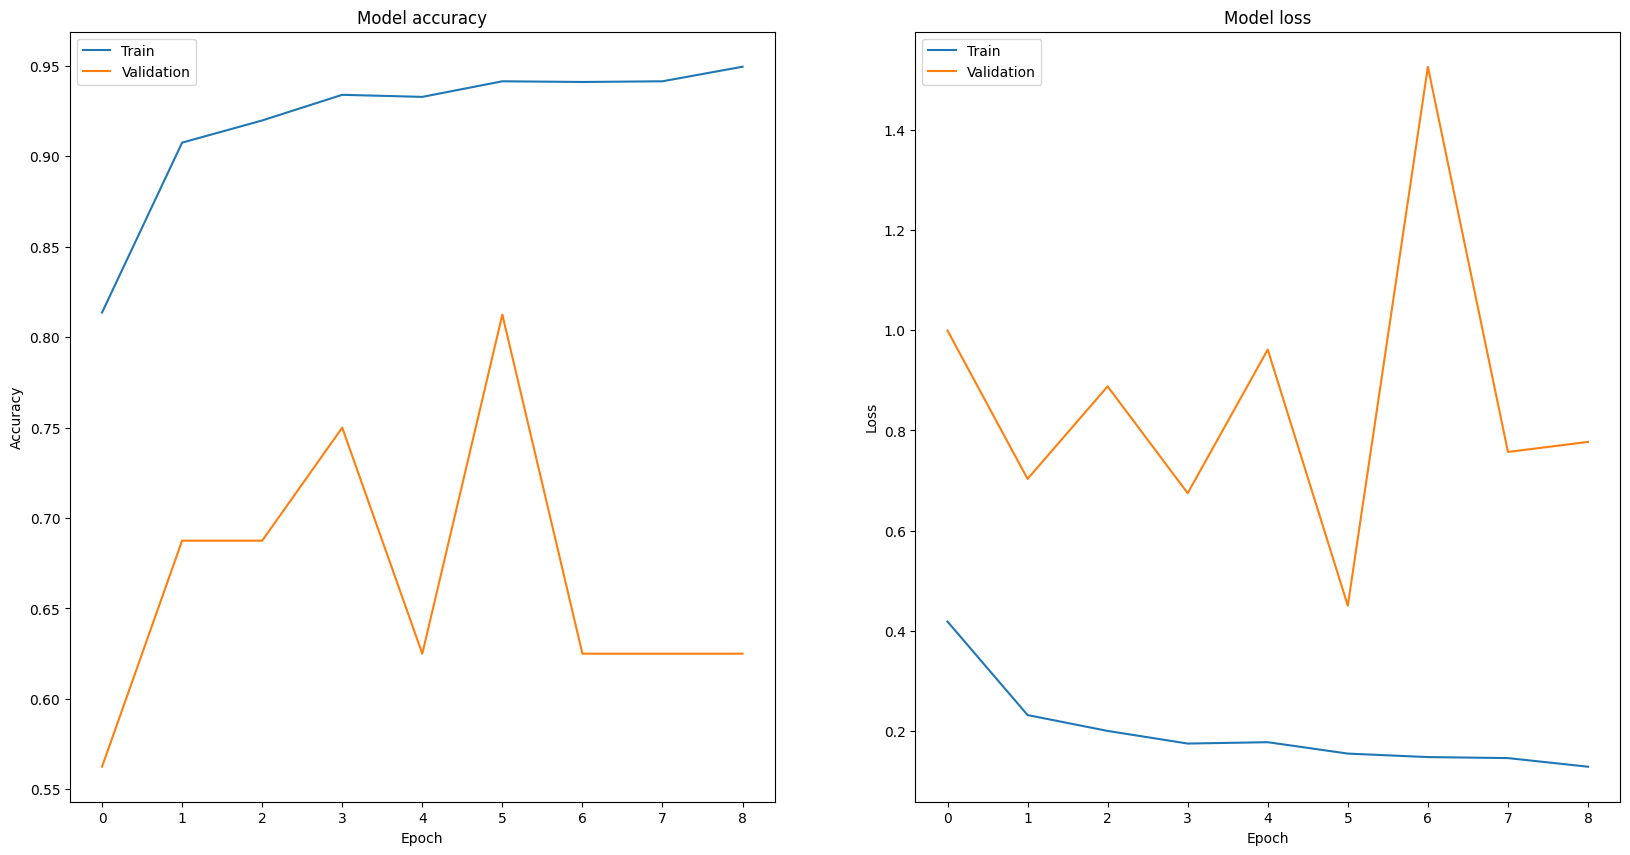

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

history = history.history

ax[0].plot(history['accuracy'])
ax[0].plot(history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history['loss'])
ax[1].plot(history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy_loss.png')
plt.show()